In [108]:
# import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [109]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
cmip6_models = ['access-cm2', 'awi-esm-1-1-lr', 'bcc-csm2-mr',
                'bcc-esm1', 'canesm5', 'cmcc-esm2',
                'fgoals-f3-l', 'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'ipsl-cm6a-lr', 'kace-1-0-g',
                'miroc6', 'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']
# cmip6_models = ['taiesm1']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

# model = cmip6_models[7]

In [111]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirUtil = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/util'
dataDirLens = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/LENS/daily/atm'

In [112]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [126]:
# LOAD LENS

tw_lens_1 = xr.open_mfdataset('%s/tw_lens_1_*.nc'%dirUtil)
tw_lens_1 = tw_lens_1.rename({'__xarray_dataarray_variable__':'tw'})
tw_lens_1_monthly_mean = tw_lens_1.tw.groupby('time.month').max(dim=['time', 'lat', 'lon'])
tw_lens_1_monthly_mean.load()

tw_lens_2 = xr.open_mfdataset('%s/tw_lens_2_*.nc'%dirUtil)
tw_lens_2 = tw_lens_2.rename({'__xarray_dataarray_variable__':'tw'})
tw_lens_2_monthly_mean = tw_lens_2.tw.groupby('time.month').max(dim=['time', 'lat', 'lon'])
tw_lens_2_monthly_mean.load()

# tx_lens = xr.open_mfdataset('%s/TASMAX/HIST-RCP85/tasmax_day_CESM1-CAM5_historical_rcp85_r%di1p1_*.nc'%(dataDirLens, 1))
# tx_lens = tx_lens.sel(time=slice('1981-01-01', '2021-12-31'))

<xarray.DataArray 'tw' (month: 12)>
array([29.74454136, 29.14808059, 28.55110991, 29.25262408, 30.2637085 ,
       31.44524354, 32.46704138, 32.3109401 , 31.446594  , 30.08930925,
       28.35335017, 29.57344922])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

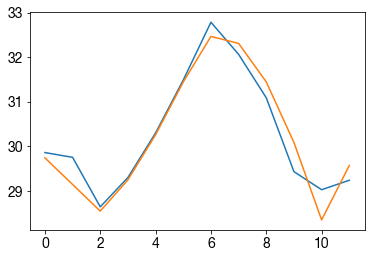

In [127]:
plt.plot(tw_lens_1_monthly_mean)
plt.plot(tw_lens_2_monthly_mean)

In [68]:
# LOAD ERA5 TX_TW_CORR MEAN

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.sel(time=slice('1981-01-01', '2014-12-31'))

tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = tx_tw_corr_full.sel(latitude=slice(60,-60)).mean(dim=['latitude', 'longitude'])

In [69]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load();
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load();
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})

In [131]:
cmip6_tx_on_tw = []

for model in cmip6_models:
    cur_cmip6_tx_on_tw = xr.open_dataset(f'output/cmip6/tx_on_tw_{model}.nc')
    cur_cmip6_tx_on_tw = cur_cmip6_tx_on_tw.sel(lat=slice(-60,60))
    cur_cmip6_tx_on_tw.load()
    cmip6_tx_on_tw.append(cur_cmip6_tx_on_tw)
    


In [133]:
cmip6_tx_on_tw = xr.concat(cmip6_tx_on_tw, dim='model')

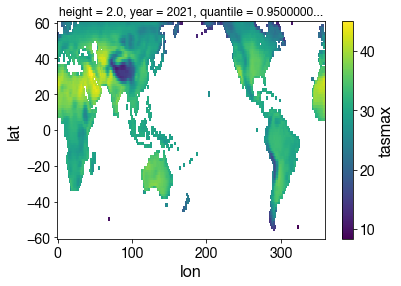

In [136]:
cmip6_tx_on_tw.tasmax.mean(dim=['model'])[-1,:,:].plot()

In [8]:
# REGRID ALL THE CMIP6 MODELS and CALC TX_TW CORR

for model in cmip6_models:
    print('opening %s'%model)
    cmip6_tw = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tw/*.nc'%(dirCMIP6, model))
    cmip6_tx = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tasmax/*day*.nc'%(dirCMIP6, model))
    
    cmip6_tx = cmip6_tx.sel(time=slice('1981', '2014'))
    cmip6_tw = cmip6_tw.sel(time=slice('1981', '2014'))
    
    cmip6_tx = cmip6_tx['tasmax']
    cmip6_tx = cmip6_tx.reindex(lat=cmip6_tx.lat[::-1])
    cmip6_tx.load();

    cmip6_tw = cmip6_tw['tw']
    cmip6_tw = cmip6_tw.reindex(lat=cmip6_tw.lat[::-1])
    cmip6_tw.load();
    
    print('regridding...')
    regridder = xe.Regridder(land_sea_mask_binary.rename({'latitude':'lat', 'longitude':'lon'}), regridMesh_global, 'bilinear', reuse_weights=True)
    land_sea_mask_binary_regrid = regridder(land_sea_mask_binary)
    
    regridder = xe.Regridder(cmip6_tx, regridMesh_global, 'bilinear', reuse_weights=False)
    cmip6_tx_regrid = regridder(cmip6_tx)
    cmip6_tw_regrid = regridder(cmip6_tw)

    cmip6_tx_regrid = cmip6_tx_regrid.where(land_sea_mask_binary_regrid)
    cmip6_tw_regrid = cmip6_tw_regrid.where(land_sea_mask_binary_regrid)

    cmip6_tx_regrid = cmip6_tx_regrid.sel(lat=slice(-60,60))
    cmip6_tw_regrid = cmip6_tw_regrid.sel(lat=slice(-60,60))
    
    regridder = xe.Regridder(annual_max_months_da_tx, regridMesh_global, 'bilinear', reuse_weights=True)
    annual_max_months_da_tx_regrid = regridder(annual_max_months_da_tx)
    annual_max_months_da_tw_regrid = regridder(annual_max_months_da_tw)
    
    print('creating warm season mask')
    # First create a boolean mask
    mask = xr.full_like(cmip6_tx.time, False, dtype=bool)

    # Iterate over the years
    for y in annual_max_months_da_tx_regrid.year:
        # Find the month of max temperature in this year
        month_of_max_tx = annual_max_months_da_tx_regrid.sel(year=y)
        month_of_max_tw = annual_max_months_da_tw_regrid .sel(year=y)

        # Set True in the mask for all days of this month in this year
        mask = mask | (cmip6_tx.time.dt.month == month_of_max_tx) | (cmip6_tx.time.dt.month == month_of_max_tw)


    # Apply the mask to select temperature data for the months of interest
    cmip6_tx_regrid = cmip6_tx_regrid.where(mask, drop=True)
    cmip6_tw_regrid = cmip6_tw_regrid.where(mask, drop=True)
    
    print('calculating correlation...')
    correlation_per_year = []

    # Iterate over the years
    for y in range(1981, 2014 + 1):
        # Select data for this year
        cmip6_tx_year = cmip6_tx_regrid.sel(time=cmip6_tx_regrid.time.dt.year == y)
        cmip6_tw_year = cmip6_tw_regrid.sel(time=cmip6_tw_regrid.time.dt.year == y)

#         print(y)
        # Calculate the correlation for this year and store it in the list
        correlation = xr.corr(cmip6_tx_year, cmip6_tw_year, dim='time')
        correlation['year'] = y  # Add a coordinate for the year
        correlation_per_year.append(correlation)

    # Combine all the DataArrays along the 'year' dimension
    correlation_per_year_da = xr.concat(correlation_per_year, dim='year')
    
    print('saving file...')
    correlation_per_year_da.to_netcdf('tx_tw_corr_%s.nc'%model)
    
    

opening taiesm1
regridding...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_192x288_120x240.nc 
 You can set reuse_weights=True to save computing time.
Reuse existing file: bilinear_721x1440_120x240.nc
creating warm season mask
calculating correlation...
saving file...


In [ ]:
# REGRID ALL THE CMIP6 MODELS and CALC TX_TW CORR

for model in cmip6_models:
    print('opening %s'%model)
    cmip6_tw = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tw/*.nc'%(dirCMIP6, model))
    cmip6_tx = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tasmax/*day*.nc'%(dirCMIP6, model))
    
    cmip6_tx = cmip6_tx.sel(time=slice('1981', '2014'))
    cmip6_tw = cmip6_tw.sel(time=slice('1981', '2014'))
    
    cmip6_tx = cmip6_tx['tasmax']
    cmip6_tx = cmip6_tx.reindex(lat=cmip6_tx.lat[::-1])
    cmip6_tx.load();

    cmip6_tw = cmip6_tw['tw']
    cmip6_tw = cmip6_tw.reindex(lat=cmip6_tw.lat[::-1])
    cmip6_tw.load();
    
    print('regridding...')
    regridder = xe.Regridder(land_sea_mask_binary.rename({'latitude':'lat', 'longitude':'lon'}), regridMesh_global, 'bilinear', reuse_weights=True)
    land_sea_mask_binary_regrid = regridder(land_sea_mask_binary)
    
    regridder = xe.Regridder(cmip6_tx, regridMesh_global, 'bilinear', reuse_weights=False)
    cmip6_tx_regrid = regridder(cmip6_tx)
    cmip6_tw_regrid = regridder(cmip6_tw)

    cmip6_tx_regrid = cmip6_tx_regrid.where(land_sea_mask_binary_regrid)
    cmip6_tw_regrid = cmip6_tw_regrid.where(land_sea_mask_binary_regrid)

    cmip6_tx_regrid = cmip6_tx_regrid.sel(lat=slice(-60,60))
    cmip6_tw_regrid = cmip6_tw_regrid.sel(lat=slice(-60,60))
    
    regridder = xe.Regridder(annual_max_months_da_tx, regridMesh_global, 'bilinear', reuse_weights=True)
    annual_max_months_da_tx_regrid = regridder(annual_max_months_da_tx)
    annual_max_months_da_tw_regrid = regridder(annual_max_months_da_tw)
    
    print('creating warm season mask')
    # First create a boolean mask
    mask = xr.full_like(cmip6_tx.time, False, dtype=bool)

    # Iterate over the years
    for y in annual_max_months_da_tx_regrid.year:
        # Find the month of max temperature in this year
        month_of_max_tx = annual_max_months_da_tx_regrid.sel(year=y)
        month_of_max_tw = annual_max_months_da_tw_regrid .sel(year=y)

        # Set True in the mask for all days of this month in this year
        mask = mask | (cmip6_tx.time.dt.month == month_of_max_tx) | (cmip6_tx.time.dt.month == month_of_max_tw)


    # Apply the mask to select temperature data for the months of interest
    cmip6_tx_regrid = cmip6_tx_regrid.where(mask, drop=True)
    cmip6_tw_regrid = cmip6_tw_regrid.where(mask, drop=True)
    
    print('calculating correlation...')
    correlation_per_year = []

    # Iterate over the years
    for y in range(1981, 2014 + 1):
        # Select data for this year
        cmip6_tx_year = cmip6_tx_regrid.sel(time=cmip6_tx_regrid.time.dt.year == y)
        cmip6_tw_year = cmip6_tw_regrid.sel(time=cmip6_tw_regrid.time.dt.year == y)

#         print(y)
        # Calculate the correlation for this year and store it in the list
        correlation = xr.corr(cmip6_tx_year, cmip6_tw_year, dim='time')
        correlation['year'] = y  # Add a coordinate for the year
        correlation_per_year.append(correlation)

    # Combine all the DataArrays along the 'year' dimension
    correlation_per_year_da = xr.concat(correlation_per_year, dim='year')
    
    print('saving file...')
    correlation_per_year_da.to_netcdf('tx_tw_corr_%s.nc'%model)
    
    

In [70]:
tx_tw_corr_mean_regrid = tx_tw_corr_mean.rename({'latitude':'lat', 'longitude':'lon'})
regridder = xe.Regridder(tx_tw_corr_mean_regrid, regridMesh_global, 'bilinear', reuse_weights=False)
tx_tw_corr_mean_regrid = regridder(tx_tw_corr_mean_regrid.tx_tw_corr)
tx_tw_corr_mean_regrid = tx_tw_corr_mean_regrid.sel(lat=slice(-60,60))

Overwrite existing file: bilinear_721x1440_120x240.nc 
 You can set reuse_weights=True to save computing time.


In [71]:
corr_spatial = []
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []


obs_slope = 0
nn = np.where((~np.isnan(tx_tw_corr_ts.tx_tw_corr.values)))[0]
X = sm.add_constant(range(nn.size))
mdl = sm.OLS(tx_tw_corr_ts.tx_tw_corr.values[nn], X).fit()
obs_slope = mdl.params[1]*10
obs_pval = mdl.pvalues[1]

for model in cmip6_models:
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
    cur_corr_ts = cur_tx_tw_corr.tx_tw_corr.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn], X).fit()
    corr_ts_slopes.append(mdl.params[1]*10)
    corr_ts_pvals.append(mdl.pvalues[1])
    
    # Assign the model as a coordinate in the current data array
    cur_tx_tw_corr = cur_tx_tw_corr.assign_coords(model=model)

    # Add the current data array to the list
    corr_spatial.append(cur_tx_tw_corr)

# Concatenate along the new dimension 'model'
corr_spatial = xr.concat(corr_spatial, dim='model')
corr_ts = np.array(corr_ts)

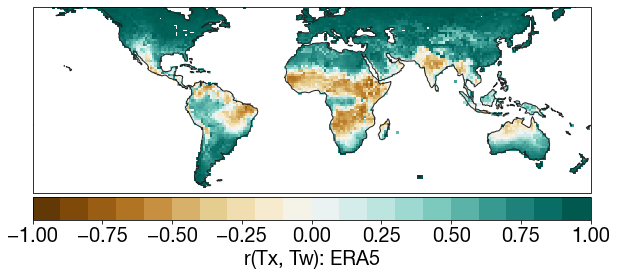

In [10]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean_regrid

c = plt.pcolormesh(tx_tw_corr_mean_regrid.lon, tx_tw_corr_mean_regrid.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


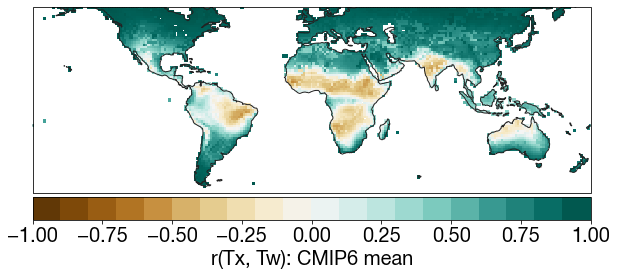

In [11]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


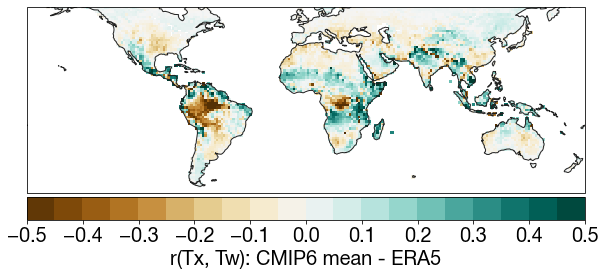

In [12]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values - tx_tw_corr_mean_regrid

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


Text(0, 0.5, 'Global mean\nr(Tx, Tw) trend\n(per decade)')

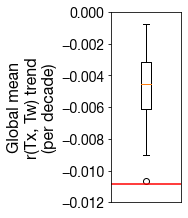

In [72]:
plt.figure(figsize=(1.25,3.5))
plt.ylim([-.012, 0])
plt.boxplot(corr_ts_slopes)
plt.plot([.5, 1.5], [obs_slope, obs_slope], '-r')
plt.xticks([])
plt.ylabel('Global mean\nr(Tx, Tw) trend\n(per decade)')

In [73]:
obs_pval

1.2432783017063355e-06

In [74]:
np.where(np.array(corr_ts_pvals)<.05)[0].size,np.array(corr_ts_pvals).size

(11, 18)

In [78]:

np.where(np.array(corr_ts_slopes)>obs_slope)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

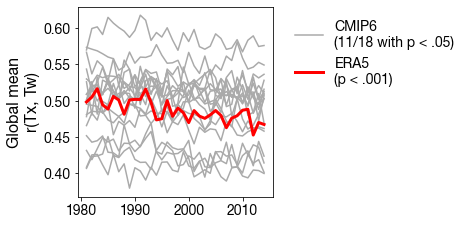

In [75]:
plt.figure(figsize=(3.5,3.5))
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[0,0:34].T, c='#aaaaaa', label='CMIP6\n(11/18 with p < .05)')
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[1:,0:34].T, c='#aaaaaa')
plt.plot(tx_tw_corr_ts.time.dt.year.values, tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')
plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [84]:
# CALC SPATIAL TREND IN CORR

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
cmip6_var = xr.open_dataset('tx_tw_corr_%s.nc'%cmip6_models[0])
cmip6_var = cmip6_var.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
cmip6_var['year'] = time_dim
cmip6_var = cmip6_var.chunk(chunks={"year": -1, "lat": 50, "lon": 50})
cmip6_var = cmip6_var.chunk({"year": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})

In [91]:

def linregress_ufunc(x, y):
    # Remove rows where either x or y is nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # If all values are nan or the length of x, y are less than 2, return nan
    if len(x) < 2 or len(y) < 2:
        return (np.nan, np.nan)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return slope, p_value

# rest of the code remains the same


def apply_trend_and_pvalue(ds, time_dim='year', x_dim='lon', y_dim='lat'):
    # Extract the year information from the time coordinates
    time_years = ds[time_dim].dt.year.values
    unique_years = np.unique(time_years)
    
    # Broadcast unique_years along the time dimension
    unique_years_broadcasted = xr.DataArray(unique_years, dims=[time_dim], coords={time_dim: ds[time_dim]})
    
    trend, p_value = xr.apply_ufunc(
        linregress_ufunc,
        unique_years_broadcasted,
        ds,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )

    trend = trend.rename("tx_tw_corr_trend")
    p_value = p_value.rename("tx_tw_corr_trend_p_value")
    
    return xr.merge([trend, p_value])





In [92]:
cmip6_var_trend = apply_trend_and_pvalue(cmip6_var['tx_tw_corr'])

In [93]:
client = Client()

In [94]:
cmip6_var_trend.compute()

<xarray.Dataset>
Dimensions:                   (lat: 81, lon: 240)
Coordinates:
  * lat                       (lat) float64 -60.0 -58.5 -57.0 ... 57.0 58.5 60.0
    height                    float64 2.0
  * lon                       (lon) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
Data variables:
    tx_tw_corr_trend          (lat, lon) float64 nan nan nan nan ... nan nan nan
    tx_tw_corr_trend_p_value  (lat, lon) float64 nan nan nan nan ... nan nan nan

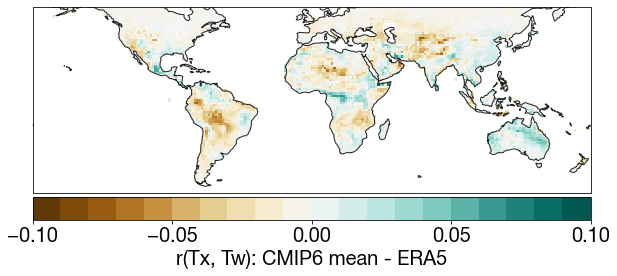

In [100]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05
midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = cmip6_var_trend.tx_tw_corr_trend.values*10

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
